Imports

In [120]:
import os
import pandas as pd
import re
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

os.getcwd()

'/Users/sergeykorepanov/PycharmProjects/pythonProject'

# Understanding the Dataset

Let's look at the first few rows of the dataset
Even from this small sample we can see a lot of missing data and data that is not relevant.

For example some of the job postings are missing `salary data` which is very important for our project.


In [27]:
df = pd.read_csv('./content/sample_data/us-software-engineer-jobs-zenrows.csv')
df.head()

,title,company,salary,rating,review_count,types,location,relative_time,hires_needed,hires_needed_exact,...,indeed_applyable,ad_id,remote_location,source_id,hiring_event_job,indeed_apply_enabled,job_location_postal,company_overview_link,activity_date,location_extras
0,Android Developer,Shockoe,NaN,0.0,0,Full-time,"Richmond, VA",30+ days ago,NaN,NaN,...,False,NaN,False,11706594,False,False,NaN,NaN,NaN,NaN
1,Web Developer,"Denios, Inc.","$45,000 - $55,000 a year",0.0,0,Full-time,"Louisville, KY",30+ days ago,ONE,1,...,True,370154371.0,False,11468052,False,True,40219.0,NaN,Active 2 days ago,NaN
2,Sr. Android Developer,The Cervantes Group,NaN,4.1,22,Full-time,Remote,6 days ago,TWO_FOUR,2,...,True,NaN,False,9570478,False,True,NaN,/cmp/The-Cervantes-Group,Active 3 days ago,NaN
3,Junior Software Engineer,Medical Knowledge Group,NaN,0.0,0,Full-time,Remote,8 days ago,ONE,1,...,True,368864426.0,False,501562,False,True,NaN,NaN,Active 3 days ago,NaN
4,"Cloud Engineer (Software Engineer Advanced, Ex...",Federal Reserve Bank of New York,NaN,4.1,548,Full-time,"Kansas City, MO",2 days ago,NaN,NaN,...,False,NaN,False,1439,False,False,NaN,/cmp/Federal-Reserve-Bank-of-New-York,NaN,NaN


## Information about data set

From the information we are able to see all type of data in our disposal.
Let list a few of them that are more important to us and describe their meaning



*   **Title** - title of the job position on which company is hiring
*   **Company** - name of the company that is hiring
*   **Salary** - Salary range that the company is offering for the position
*   **Location** - Location where the office of the company is located
*   **Types** - Type of employment: Full-time, Part-time, Contract, Internship, Temporary

Other data points are considered unrelated for our goals. Therefore, let's remove them.



In [50]:
df.info()
columns_to_drop = ['rating', 'review_count', 'relative_time', 'hires_needed', 'hires_needed_exact',
                   'urgently_hiring', 'remote_work_model', 'snippet', 'dradis_job', 'link', 'new_job',
                   'job_link', 'sponsored', 'featured_employer', 'indeed_applyable', 'ad_id', 'remote_location',
                   'source_id', 'hiring_event_job', 'indeed_apply_enabled', 'job_location_postal', 'company_overview_link',
                   'activity_date', 'location_extras']
df_cleaned = df.drop(columns_to_drop, axis=1)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 58433 entries, 0 to 58432
Data columns (total 29 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   title                  58433 non-null  object 
 1   company                58430 non-null  object 
 2   salary                 18103 non-null  object 
 3   rating                 58433 non-null  float64
 4   review_count           58433 non-null  int64  
 5   types                  42577 non-null  object 
 6   location               58433 non-null  object 
 7   relative_time          58433 non-null  object 
 8   hires_needed           11857 non-null  object 
 9   hires_needed_exact     18439 non-null  object 
 10  urgently_hiring        58433 non-null  bool   
 11  remote_work_model      22804 non-null  object 
 12  snippet                58425 non-null  object 
 13  dradis_job             58433 non-null  bool   
 14  link                   58433 non-null  object 
 15  ne

## Cleaned Data Set
Here is the data remained after cleaning

In [5]:
df_cleaned.head()

,title,company,salary,types,location
0,Android Developer,Shockoe,NaN,Full-time,"Richmond, VA"
1,Web Developer,"Denios, Inc.","$45,000 - $55,000 a year",Full-time,"Louisville, KY"
2,Sr. Android Developer,The Cervantes Group,NaN,Full-time,Remote
3,Junior Software Engineer,Medical Knowledge Group,NaN,Full-time,Remote
4,"Cloud Engineer (Software Engineer Advanced, Ex...",Federal Reserve Bank of New York,NaN,Full-time,"Kansas City, MO"


## Normalising Data
After we cleaned irrelevant data we need to normalise salary ranges. In the code snippet bellow we can see that salary range for a position can be stated as "a year", "a month", "a week", "an hour"

- First of all we will convert salary data to dollars per year.

- And after we will split range data to min_salary and max_salary for the role

### Converting Salary Data
let's look at the unique values in the 'salary' column to understand the data better

In [6]:
# Get unique values after dropping NaNs
unique_salaries = set(df_cleaned['salary'].unique())
unique_salaries_df = pd.DataFrame(unique_salaries)
unique_salaries_df.head(n=100)

,0
0,NaN
1,$60 - $66 an hour
2,"$105,448 - $204,578 a year"
3,"$54,180 - $100,620 a year"
4,"$170,000 - $210,000 a year"
...,...
95,"$68,600 - $132,500 a year"
96,From $30 an hour
97,$36 - $75 an hour
98,"$105,400 - $124,000 a year"


### Converting to Yearly Salary
From previous snippet we see that the salary appears in different formats and rates. 
- a year, a month, a week, an hour
- range and fixed rate

- Let's try to convert all of them to yearly salary

In [56]:
# Cleaning symbols
def clean_text(text: str):
    if pd.isna(text):
        return "NaN"
    # Split the text by ' - ' to separate the salary range
    cleaned_text = (text
                    .lower()
                    .replace('$', '')
                    .replace(',', '')
                    .replace(' - ', ' '))

    return cleaned_text

df_cleaned['salary_temp'] = df_cleaned['salary'].apply(clean_text)

df_cleaned['salary_temp']

0                       NaN
1        45000 55000 a year
2                       NaN
3                       NaN
4                       NaN
                ...        
58428                   NaN
58429                   NaN
58430                   NaN
58431                   NaN
58432                   NaN
Name: salary_temp, Length: 58433, dtype: object

In [57]:
# Define the assumption for hours worked per year
hours_per_year = 1892  # Statistical data from clockify 

def convert_range_match(match: re.Match[str]) -> object:
    if match.group(3) == 'a year':
        yearly_min = float(match.group(1))
        yearly_max = float(match.group(2))
    if match.group(3) == 'a month':
        yearly_min = float(match.group(1)) * 12
        yearly_max = float(match.group(2)) * 12
    if match.group(3) == 'a week':
        yearly_min = float(match.group(1)) * 52
        yearly_max = float(match.group(2)) * 52
    if match.group(3) == 'a day':
        yearly_min = float(match.group(1)) * 260
        yearly_max = float(match.group(2)) * 260    
    if match.group(3) == 'an hour':
        yearly_min = float(match.group(1)) * hours_per_year
        yearly_max = float(match.group(2)) * hours_per_year        
    return f"{yearly_min:.0f} {yearly_max:.0f}"

def convert_fixed_match(match: re.Match[str]) -> object:
    if match.group(2) == 'a year':
        yearly_min = float(match.group(1))
        yearly_max = yearly_min
    if match.group(2) == 'a month':
        yearly_min = float(match.group(1)) * 12
        yearly_max = yearly_min
    if match.group(2) == 'a week':
        yearly_min = float(match.group(1)) * 52
        yearly_max = yearly_min
    if match.group(2) == 'a day':
        yearly_min = float(match.group(1)) * 260
        yearly_max = yearly_min    
    if match.group(2) == 'an hour':
        yearly_min = float(match.group(1)) * hours_per_year
        yearly_max = yearly_min        
    return f"{yearly_min:.0f} {yearly_max:.0f}"

def converter(salary: str):
    if salary == 'NaN':
        return salary
    
    range_pattern = r'(\d+\.?\d*) (\d+\.?\d*) (a year|a month|an hour|a week|a day)'
    fixed_pattern = r'(\d+\.?\d*) (a year|a month|an hour|a week|a day)'
    
    range_match = re.search(range_pattern, salary)
    fixed_match = re.search(fixed_pattern, salary)
    
    if range_match:
        return convert_range_match(range_match)

    if fixed_match:
        return convert_fixed_match(fixed_match)
# Apply the function to the 'salary' column
df_cleaned['salary_temp'] = df_cleaned['salary_temp'].apply(converter)
df_cleaned['salary_temp']

salary_split = df_cleaned['salary_temp'].str.split(expand=True)

# Assigning the split parts to 'min_salary' and 'max_salary' columns
df_cleaned['min_salary'] = salary_split[0]
df_cleaned['max_salary'] = salary_split[1]

df_cleaned.drop(columns='salary_temp', inplace=True)
dataframe = df_cleaned.dropna(subset="salary")
dataframe

,title,company,salary,types,location,min_salary,max_salary
1,Web Developer,"Denios, Inc.","$45,000 - $55,000 a year",Full-time,"Louisville, KY",45000,55000
7,"Real-Time, Embedded Software Engineer",Checkmate Partners,"$100,000 - $200,000 a year",Full-time,"San Francisco Bay Area, CA",100000,200000
13,Software Engineer (Clearance Required),LOCKHEED MARTIN CORPORATION,"$3,000 a week",NaN,"Annapolis Junction, MD",156000,156000
14,Cyber Security Operation Center Manager (SOC),Goliath Solutions Group,$15 - $20 an hour,Full-time,"Fairview, TX",28380,37840
17,DevOps Engineer - Very Profitable Start-up,TechTalent NW,"$125,000 - $170,000 a year",Full-time,"Bellevue, WA",125000,170000
...,...,...,...,...,...,...,...
58417,Staff Software Engineer - Analytics Tools,Indeed,"$132,000 - $192,000 a year",Full-time,Remote,132000,192000
58420,"Real-Time, Embedded Software Engineer",Checkmate Partners,"$100,000 - $200,000 a year",Full-time,"San Jose, CA",100000,200000
58423,Staff Software Engineer - Apply Management,Indeed,"$132,000 - $192,000 a year",Full-time,Remote,132000,192000
58424,Full Stack Staff Software Engineer - Indeed In...,Indeed,"$132,000 - $192,000 a year",Full-time,"Austin, TX",132000,192000


## Descriptive analysis

In [77]:
df_copy = dataframe.copy()
df_copy['min_salary'] = df_copy['min_salary'].astype(int, copy=True)
df_copy['max_salary'] = df_copy['max_salary'].astype(int, copy=True)

df_copy.describe()

,min_salary,max_salary
count,18103.000000,18103.000000
mean,101771.176048,134562.711153
std,36227.249781,45883.915471
min,10000.000000,10000.000000
25%,80000.000000,104060.000000
50%,100000.000000,135000.000000
75%,125000.000000,160000.000000
max,400000.000000,500000.000000


### Most frequent numbers

In [78]:
df_copy.mode()

,title,company,salary,types,location,min_salary,max_salary
0,Senior Software Engineer,Indeed,"$132,000 - $192,000 a year",Full-time,Remote,100000,150000


### Variance

In [80]:
df_copy.var(numeric_only=True)

min_salary    1.312414e+09
max_salary    2.105334e+09
dtype: float64

### Standard deviation

In [81]:
df_copy.std(numeric_only=True)

min_salary    36227.249781
max_salary    45883.915471
dtype: float64

### Range

In [82]:
df_copy.max(numeric_only=True) - df_copy.min(numeric_only=True)

min_salary    390000
max_salary    490000
dtype: int64

### Interquartile Range

In [84]:
df_copy.quantile(0.75, numeric_only=True) - df_copy.quantile(0.25, numeric_only=True)

min_salary    45000.0
max_salary    55940.0
dtype: float64

### Distribution analysis

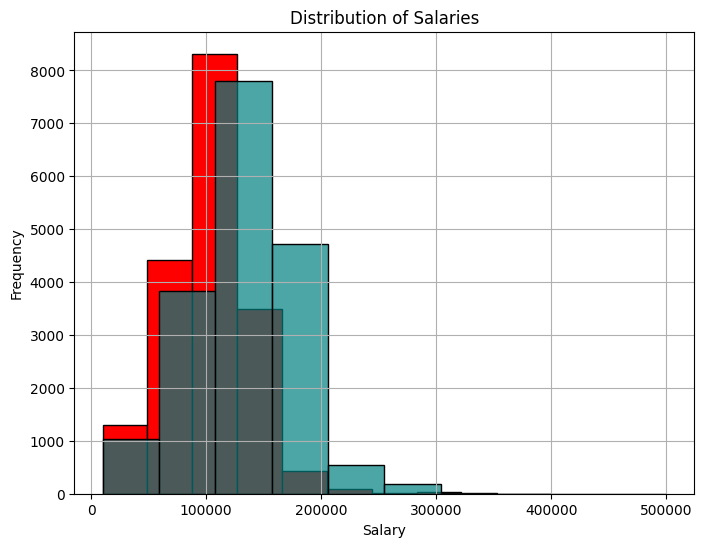

In [111]:
plt.figure(figsize=(8, 6))
plt.hist(df_copy['min_salary'], bins=10, color='red', edgecolor='black', stacked=True)
plt.hist(df_copy['max_salary'], bins=10, color=(0.0, 0.5, 0.5, 0.7), edgecolor='black', stacked=True)
plt.title('Distribution of Salaries')
plt.xlabel('Salary')
plt.ylabel('Frequency')
plt.grid(True)
plt.show() 

### Frequency table

In [119]:
# Frequency table of salaries
min_salaries = pd.cut(df_copy['min_salary'], bins=10, precision=0)
frequency_table = pd.Series(min_salaries).value_counts().sort_index()
print("Min Salary frequency Table:")
print(frequency_table)

max_salaries = pd.cut(df_copy['max_salary'], bins=10, precision=0)
frequency_table = pd.Series(max_salaries).value_counts().sort_index()
print("\nMax Salary frequency Table:")
print(frequency_table)


Min Salary frequency Table:
min_salary
(9610.0, 49000.0]       1308
(49000.0, 88000.0]      4425
(88000.0, 127000.0]     8320
(127000.0, 166000.0]    3474
(166000.0, 205000.0]     440
(205000.0, 244000.0]      95
(244000.0, 283000.0]       7
(283000.0, 322000.0]      32
(322000.0, 361000.0]       0
(361000.0, 400000.0]       2
Name: count, dtype: int64

Max Salary frequency Table:
max_salary
(9510.0, 59000.0]       1031
(59000.0, 108000.0]     3825
(108000.0, 157000.0]    7794
(157000.0, 206000.0]    4724
(206000.0, 255000.0]     541
(255000.0, 304000.0]     176
(304000.0, 353000.0]       8
(353000.0, 402000.0]       2
(402000.0, 451000.0]       1
(451000.0, 500000.0]       1
Name: count, dtype: int64


### Box plot of salaries by location

/var/folders/4j/wp8z1fz91ml2zmf4v20vg4980000gn/T/ipykernel_11416/1106610445.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='location', y='min_salary', data=df_copy, palette='pastel')


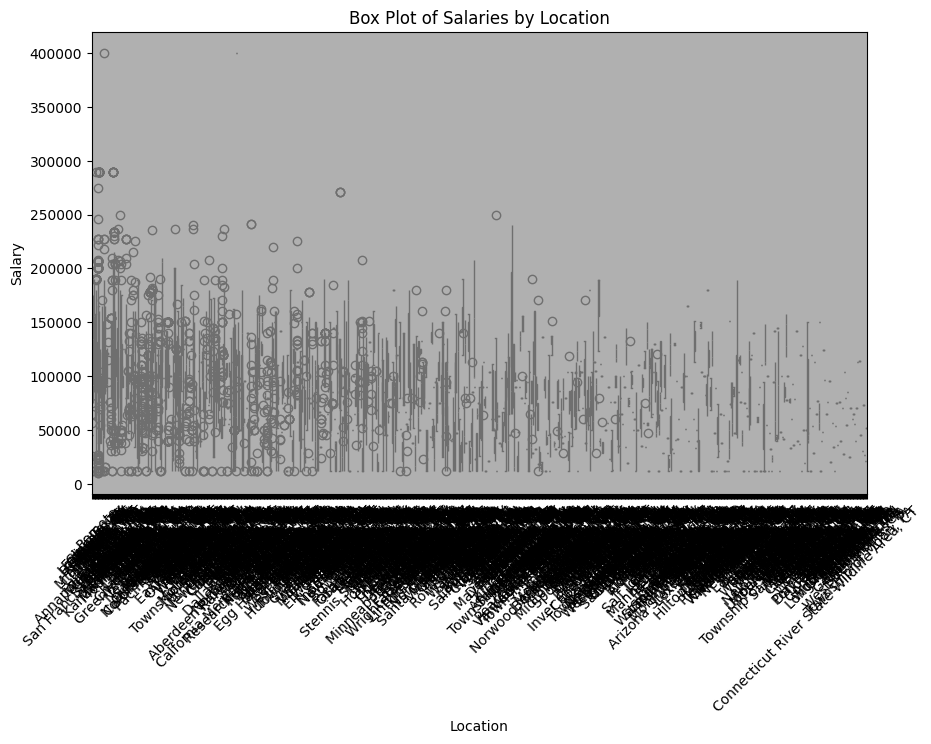

In [122]:
plt.figure(figsize=(10, 6))
sns.boxplot(x='location', y='min_salary', data=df_copy, palette='pastel')
plt.title('Box Plot of Salaries by Location')
plt.xlabel('Location')
plt.ylabel('Salary')
plt.xticks(rotation=45)
plt.grid(True)
plt.show()

### Correlation coefficient

In [124]:
location_mapping = {location: i for i, location in enumerate(df_copy['location'].unique())}
df_copy['location_encoded'] = df_copy['location'].map(location_mapping)

# Compute correlation coefficient
correlation_coefficient = df_copy['min_salary'].corr(df_copy['location_encoded'])

print("correlation Coefficient:", correlation_coefficient)

correlation Coefficient: -0.2564043071164041
